In [1]:
import pandas as pd
import numpy as np
import xarray as xr

import scipy.stats as stats
import matplotlib.pyplot as plt

import boto3
from io import BytesIO

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# testing file
# file = xr.open_dataset('/Users/victoriaford/Downloads/ASOSAWOS_72053900165.nc')
file = xr.open_dataset('/Users/victoriaford/Desktop/Train_Files/CAHYDRO_TREC1.nc') # has flagged vars

df = file.to_dataframe()

In [3]:
df = df.reset_index() 
df['month'] = pd.to_datetime(df['time']).dt.month # sets month to new variable
df['year'] = pd.to_datetime(df['time']).dt.year # sets year to new variable

In [4]:
def create_bins(data, bin_size=0.25):
    '''Create bins from data covering entire data range'''

    # set up bins
    b_min = np.floor(np.nanmin(data))
    b_max = np.ceil(np.nanmax(data))
    bins = np.arange(b_min - bin_size, b_max + (3. * bin_size), bin_size)

    return bins

In [5]:
def iqr_standardize(df, var):
    q1 = df[var].quantile(0.25)
    q3 = df[var].quantile(0.75)
    iqr = q3 - q1
    
    return (df[var].values - df[var].median()) / iqr

In [8]:
df2 = df.loc[df['month'] == 1]

In [11]:
len(df2.year.unique())

12

In [6]:
def plot_gap_check(df, month, var, network):
    
    df = df.loc[df['month'] == month]

    bucket_name = 'wecc-historical-wx'
    directory = '3_qaqc_wx'
    
    # standardize against IQR range
    df_month_iqr = iqr_standardize(df, var)
    
    # determine number of bins
    bins = create_bins(df_month_iqr)
    
    # plot histogram
    ax = plt.hist(df_month_iqr, bins=bins, log=False, density=True, alpha=0.3);
    xmin, xmax = plt.xlim()
    plt.ylim(ymin=0.1)

    # plot pdf
    mu = np.nanmean(df_month_iqr)
    sigma = np.nanstd(df_month_iqr)
    y = stats.norm.pdf(bins, mu, sigma)
    l = plt.plot(bins, y, 'k--', linewidth=1)
    
    # add vertical lines to indicate thresholds where pdf y=0.1
    pdf_bounds = np.argwhere(y > 0.1)

    # find first index
    left_bnd = round(bins[pdf_bounds[0][0] -1])
    right_bnd = round(bins[pdf_bounds[-1][0] + 1])
    thresholds = (left_bnd - 1, right_bnd + 1)

    plt.axvline(thresholds[1], color='r') # right tail
    plt.axvline(thresholds[0], color='r') # left tail
    
    # flag (visually) obs that are beyond threshold
    for bar in ax[2].patches:
        x = bar.get_x() + 0.5 * bar.get_width()
        if x > thresholds[1]: # left tail
            bar.set_color('r')
        elif x < thresholds[0]: # right tail
            bar.set_color('r')

    # title and useful annotations
    plt.title('Distribution gap check pt 2: {0}: {1}'.format(df['station'].unique()[0], var), fontsize=10);
    plt.annotate('Month: {}'.format(month), xy=(0.025, 0.95), xycoords='axes fraction', fontsize=8);
    plt.annotate('Mean: {}'.format(round(mu,3)), xy=(0.025, 0.9), xycoords='axes fraction', fontsize=8);
    plt.annotate('Std.Dev: {}'.format(round(sigma,3)), xy=(0.025, 0.85), xycoords='axes fraction', fontsize=8);
    plt.ylabel('Frequency (obs)')
    
    # save figure to AWS
    img_data = BytesIO()
    plt.savefig(img_data, format='png')
    img_data.seek(0)
    
    s3 = boto3.resource('s3')
    bucket = s3.Bucket(bucket_name)
    figname = 'qaqc_dist_gap_part2_check_{0}_{1}_{2}'.format(df['station'].unique()[0], var, month)
    bucket.put_object(Body=img_data, ContentType='image/png',
                     Key='{0}/{1}/qaqc_figs/{2}.png'.format(
                     directory, network, figname))

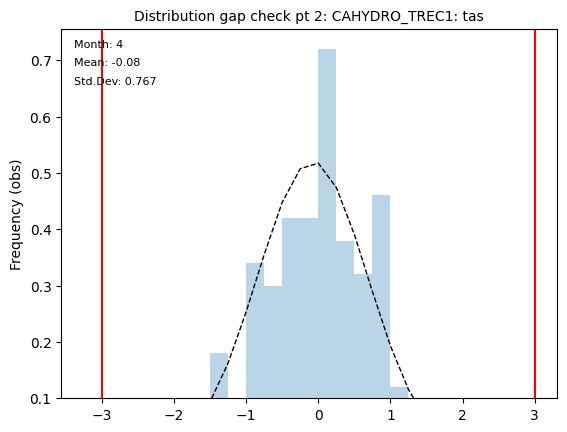

In [7]:
plot_gap_check(df, month=4, var='tas', network='CAHYDRO')

In [ ]:
def qaqc_dist_gaps_part2(df, min_num_months=5, network, plot=True):
    """
    Part 2 / monthly check
        - compare all obs in a single month, all years
        - histogram created from all obs and gaussian distribution fitted
        - threshold values determined using positions where fitted freq falls below y=0.1
        - rounds outwards to next integer plus one
        - going outwards from center, distribution is scanned for gaps which occur outside threshold
        - obs beyond gap are flagged
    Goal: identifies individual suspect observations and flags the entire month  
    """
    
    # run through every var, excluding qaqc/duration/method vars
    vars_to_remove = ['index','station','qc', 'duration', 'method', 'lat', 'lon', 'elevation', 'time', 'month', 'year', 'sfcWind_dir'] # list of var substrings to exclude if present in var
    vars_to_check = [var for var in df.columns if not any(True for item in vars_to_remove if item in var)] # remove all non-primary variables
    
    # run through each month
    for m in range(1):
        df_month = df.loc[df['month'] == m+1]
        
        # determine if we have enough months to run distribution check
        if len(df_month.year.unique()) < min_num_months:
            print('{} has too short of a {} observation record for month #{} to proceed through the monthly distribution qa/qc checks'.
                 format(df['station'].unique()[0],
                       var,
                       m))

        plot_gap_check(df_month, var='tas')
        
        
    ## Question: Do we need "all", "flagged_only", "none" options instead?
    if plot = True:
        plot_gap_check(df, month=4, var='tas', network='CAHYDRO')
                
    
#     return df
    